# Data Preprocessing
This notebook contains functions for converting audio files (in .wav format) to mel spectrograms and creating dataset with drunk/sober labels (sober = 0, drunk = 1).

# Prerequisite: Mount your gdrive and set root

The root is currently set to our google drive's directory. You may need to change this to the directory that contains all the preprocessed data. 

In [ ]:
import os
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
root = '/gdrive/My Drive/root_for_submission/'

Mounted at /gdrive


# Import libraries

In [ ]:
import argparse
import torch
import math
import librosa
import librosa.display
import json
import csv
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Utilities and basic settings

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
    print("using cuda")
else:
    device=torch.device('cpu')
    print("using cpu")

batch_size = 32

data_path = '/gdrive/My Drive/2020 Fall CS470 Group Project/CS470 group project wav recordings/'
# csv_path = '/gdrive/My Drive/2020 Fall CS470 Group Project/data_loader.csv'
csv_path = '/gdrive/My Drive/2020 Fall CS470 Group Project/held_out.csv'

using cuda


# Define functions for preprocessing

KAISD_data          : The data class for input/output

get_melspectrograms : Transforms the data in path into mel spectrograms 

spec_to_image : Normalize the data 

load_audio : wrapper function for transforming list of data 



In [ ]:
class KAISD_data( Dataset):
  def __init__(self, base_path, csv_path):
    self.df = pd.read_csv(csv_path)
    self.data = []
    self.labels = []
    self.c2i={}
    self.categories = sorted(self.df['label'].unique())
    for i, category in enumerate(self.categories):
      self.c2i[category]=i
    for j in tqdm(range(len(self.df))):
      row = self.df.iloc[j]
      file_path = os.path.join(base_path,row['filename'])
      file_data = load_audio(file_path, 8)
      self.data += file_data
      self.labels += [self.c2i[row['label'] ] ] * len (file_data)
  def __len__(self):
    return len(self.data)
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

def get_melspectrograms( file_path, sr = None, max_sec = 8 ):
  wav_segments = []
  spec_dbs = []
  wav,sr = librosa.load(file_path,sr=22050)
  while wav.shape[0] >= max_sec*sr:
    wav_segments.append (wav[:max_sec*sr])
    wav = wav[max_sec*sr:]
  #last segment which will be shorter that max_sec
  wav =np.pad(wav,int(np.ceil((max_sec*sr-wav.shape[0])/2)),mode='reflect')
  wav_segments.append( wav)
  for wav in wav_segments:
    spec=librosa.feature.melspectrogram( wav, sr=sr, n_fft=2048, hop_length = 512,
                                         n_mels=128, fmin=20,fmax=8300 )
    spec_db=librosa.power_to_db( spec, top_db=80 )
    spec_dbs.append ( spec_db)
  return spec_dbs

def spec_to_image( spec ):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + 1e-6)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

def load_audio( file_path, max_sec):
  data = []
  spec_dbs = get_melspectrograms( file_path, max_sec )
  for db in spec_dbs:
    data.append (spec_to_image(db)[np.newaxis,...])
  return data

# Create data_loader and save

Here, we save the transformed the loaded data into the given path. Pytorch's Dataloader package was used.

In [ ]:
data_loader_PATH = root + 'held_out.pth' #'data_loader.pth'
full_data = KAISD_data(data_path, csv_path)
full_loader = DataLoader(full_data, batch_size=batch_size, shuffle=True)
torch.save(full_loader, data_loader_PATH)

100%|██████████| 2/2 [00:35<00:00, 17.78s/it]


# Visualizing data

Here, we provide the a visualization for the intermediate stages for preprocessing.
The pipeline is as follows:

  file_path --> load as waveform --> fourier transform --> spectrogram -->**mel spectrogram** 

## Waveforms

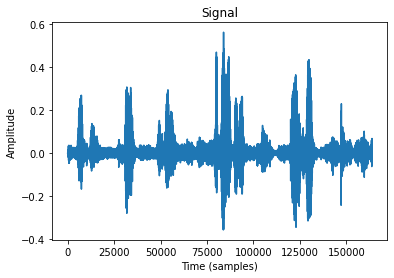

In [ ]:
waveform, sample_rate = librosa.load(data_path + '/example_audio.wav')
plt.plot(waveform);
plt.title('Signal');
plt.xlabel('Time (samples)');
plt.ylabel('Amplitude');

## Fourier Transform

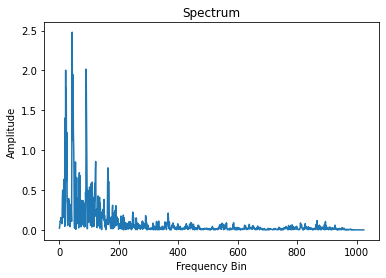

In [ ]:
n_fft = 2048
ft = np.abs(librosa.stft(waveform[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

## Spectrogram

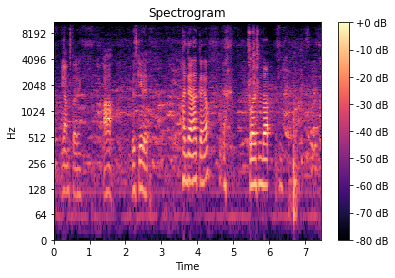

In [ ]:
spec = np.abs(librosa.stft(waveform, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sample_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

## Mel Spectrogram

<class 'numpy.ndarray'>
(1, 128, 345)


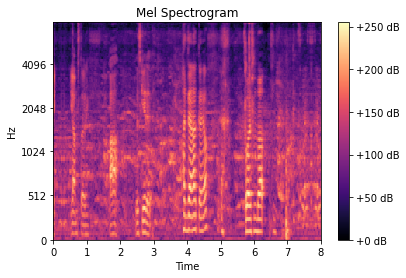

In [ ]:
a = load_audio(data_path + '/example_audio.wav', 8)
print(type(a[0]))
print(a[0].shape)
#librosa.display.specshow( a.squeeze(0)) 
librosa.display.specshow(a[0].squeeze(0), y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB')